## **Minimum Vertex Cover**

# Introduction

**Vertex Cover (VC) Problem**:   

- **[Instance]** Graph $G(V, E)$.
- **[Feasible Solutions]** A subset $C  \subseteq V$ such that for all $e = {u,v}  \in$ E , $e \cap C \neq \phi$.
- **[Value]** The value of a solution is the size of the cover $|C|$, and the goal is to minimize it.

**Weighted Vertex Cover Problem**:   

- **[Instance]** Graph $G(V, E)$ and a positive integer weight function $w : V \rightarrow Z$ on the vertices.
- **[Feasible Solutions]** A subset $C  \subseteq V$ such that $\forall e = {u,v} \in E, e \cap C \neq \phi$.
- **[Value]** The value of a solution is the weight of the cover: $w(C)^{*}$, and the goal is to minimize it.
---
**Implementation:**   
We use three metrics for the comparision of algorithms:
1. Performance Ratio: ratios of lengths of vertex covers (wrt Brute force or ILP).
2. Execution time of various algorithms.
3. Hamming distance of brute force vertex cover with other algorithms.
---
**Hamming distance** is a metric for comparing two binary data strings. While comparing two binary strings of equal length, Hamming distance is the number of bit positions in which the two bits are different.   

*For example:*    
For 6 vertices (numbered 0 to 5),
- Optimal (brute force) vertex cover: {1,2}    
- Vertex cover according to G1 Algorithm: {1,3,5}   

Characteristic Vector:
- Optimal: 011000
- G1 Algo: 010101   

Hamming Distance: 3 (3 locations where bits are different - 2,3,5)

---

In order to calculate the Hamming distance between two strings a and b, we perform the XOR operation, (a⊕b), and then count the total number of 1s in the resultant string.

# Import

In [ ]:
%%capture
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
import random
import numpy as np
import scipy
from scipy.optimize import linprog
from mpl_toolkits.mplot3d import Axes3D
from math import inf
from math import ceil
import time
import itertools
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','svg')

In [ ]:
%%capture
!pip install mip
from mip import Model, xsum, minimize, BINARY

# Exact Algorithms

## Brute Force

### **Algorithm Brute Force**
**Input:** Graph $G$ (with vertex set $V$ and edge set $E$). [Networkx graph object]   
**Output:** Minimum vertex cover.
1. Iterate through all subsets of vertex in order of size.
2. Check if our subset is a vertex cover.
3. Calculate the cost function(size of vertex cover) and store it's minimum.
---
**Implementation:**
- Initial implementation was generation of all permutations of all lengths, which took more time.
- This was later pruned by generating permutations in increasing order of length, and breaking when we get a vertex cover (this will, by default be the min vertex cover).
- Graph is dict {1:[2,3,4], 2: [1,3,4,5]}
- Subset is a list [5,6,7,8] 
---
**Parameterization:**
- *ALL* denotes whether to generate all possible minimum vertex covers. This will be used in finding minimum hamming distance wrt another vertex cover.


In [ ]:
def check_if_vertex_cover(graph, subset):
    for vertex in graph.keys():
        if vertex in subset:
            continue
        for adjacent_vertex in graph[vertex]:
            if adjacent_vertex not in subset:
                return False

    return True 

class Brute:
    minSize=100000
    vertex_cover=[]
    all_vertex_covers = []

def brute_force(graph_object, ALL = False): 
    brut = Brute()
    # Convert into an adjacency list
    graph = nx.to_dict_of_lists(graph_object)
    V = [x for x in graph.keys()] 
    # Generate all Subsets and check
    found = False
    for i in range(1,len(V)+1):

        # Generate all subsets of a given length i
        subsets_i = list(itertools.combinations(V, i))
        for subset in subsets_i:
            if (check_if_vertex_cover(graph,subset) == True):
                found = True
                brut.vertex_cover = list(subset[:])
                if (ALL == True):
                    brut.all_vertex_covers.append(brut.vertex_cover)
        if found == True:
            break
    if ALL == False:
        return brut.vertex_cover
    else:
        return brut.all_vertex_covers

In [ ]:
# Plots the networkx graph
def plot_graph(example_graph_object):
    example_graph = nx.to_networkx_graph(example_graph_object)
    pos = nx.spiral_layout(example_graph, resolution=0.7)  # positions for all nodes
    nx.draw(example_graph, pos, with_labels=True)
    labels = nx.get_edge_attributes(example_graph,'weight')
    nx.draw_networkx_edge_labels(example_graph,pos,edge_labels=labels)
    plt.axis()
    plt.show()

## Integer Linear Programming
**Input:** Graph $G$ (with vertex set $V$ and edge set $E$). [Networkx graph object]   
**Output:** Minimum vertex cover.

$\begin{align}
\text{min} \quad & \sum_{i = 1}^{m} w_{v} x_{v}, \\
\text{subject to} \\
&  x_{u}\ + \ x_{v} \geq 1 \ ,\  \forall \ e =( \ u,\ v)\  \in \ U \\
& x_{v} \in \{0,1\} , \ \forall \ v\  \in \ V \\
\end{align}$

---
###**Notation**
$x_{v} = \begin{cases}
& 1 \quad \text{ if the vertex ${v}$ is included in the set cover, }  \\
& 0 \quad \text{ otherwise}.
\end{cases}$

$w_{v}$ is the weight of the vertex ${v}$.

The first inequality implies that for each edge, atleast one vertex is included in the vertex cover.


---
**Implementation**
- If no weights are passed, we create an array with all weights = 1 to have a common implementation for weighted and unweighted case.


In [ ]:
def ilp(graph_object, weights):
    m = Model("ILP-Vertex Cover")
    E = list(graph_object.edges())
    # Convert into an adjacency list
    graph = nx.to_dict_of_lists(graph_object)
    n = len(graph.keys())

    # Xi's || vertex - whether to include or not
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    # If no weights are passed, initialize the weights to 1
    if len(weights) == 0:
        for i in range(n):
            weights.append(1)

    # objective function: minimize the cost
    m.objective = minimize(xsum(x[i]*weights[i] for i in range(n)))

    # constraints: for each edge, atleast one vertex is included in the vertex cover
    for edge in E:
        m += (x[edge[0]] + x[edge[1]]) >= 1

    # optimizing
    m.optimize()

    # converting indices to vertex cover
    vertex_cover = [i for i in range(n) if x[i].x >= 0.99]
    
    return vertex_cover

# Approximation Algorithms

## Maximal Matching

### **Algorithm Maximal Matching**
**Input:** Graph $G$ (with vertex set $V$ and edge set $E$). [Networkx graph object]   
**Output:** Minimum vertex cover.
1. Pick any maximal matching $M$ which is a subset of $E$ in $G$.
2. Add all vertices matched in $M$ to $C$.
3. Return $C$.
---
### **Performance Ratio: 2**
- Since $M$ is a maximal matching, all edges in $E - M$ are such that at least one of their end-points is incident to some $e \in M$ (otherwise, that edge could be added to $M$ to provide a larger matching).
- Thus every edge in $E$ has at least one end-point in $C$.
- To see that the ratio is 2, consider the edges in $M$. To cover these edges we need at least $|M|$ vertices, since no two of them share a vertex. 
- This implies that the optimal vertex cover has size at least $|M|$. 
- The cover C contains exactly **$2*|M|$** vertices.

---
**Implementation:**
- We find the maximal matching using networkx's max_weight_matching function.

In [ ]:
def mm_algo(graph_object):
    # Set of edges
    maximal_matching = nx.max_weight_matching(graph_object)
    C = []
    for edge in maximal_matching:
        C.append(edge[0])
        C.append(edge[1])

    return C

## G1 Approximation

### **Algorithm G1**
**Input:** Graph $G$ (with vertex set $V$ and edge set $E$). [Networkx graph object]   
**Output:** Minimum vertex cover.
1. Initialize $C$ to an empty set.
2. While $E$ is not empty:
    1. Pick any edge $e$ which belongs to $E$ and choose an end-point $v$ of $e$.
    2. Add this vertex $v$ to $C$.
    3. Remove all the edges from $E$ whose one end-point is $v$.

3. Return $C$.
---
### **Performance Ratio: O(log(|V|))**

- Consider the following bipartite graph
$B = (L, R, E)$. 
- The vertex set $L$ consists of $r$ vertices. The vertex set $R$ is further sub-divided into $r$ sets called $R_{1}, . . . , R_{r}$. 
- Each vertex in
$R_{i}$ has an edge to $i$ vertices in $L$ and no two vertices in $R_{i}$ have a
common neighbour in $L$; thus, $|R_{i}| = \lfloor r/i \rfloor$.
- It follows that each
vertex in $L$ has degree at most $r$ and each vertex in $R_{i}$ has degree $i$.
- The total number of vertices $n = \theta (r log r)$.
- Suppose that (out of sheer bad luck) the algorithm considers an edge out of $R_{r}$ first, choosing the end-point in $R$ as the vertex to be placed in the cover.
- Then it picks an edge out of $R_{r−1}$, again choosing its end-point in $R$ for the
cover $C$; and, so on. 
- Therefore the vertex cover chosen is $C = R$. 
- But $L$ is itself a vertex cover since the graph is bipartite. 
- It follows that the ratio achieved by this algorithm is no better than $|R|/|L| = \Omega (log n)$.

In [ ]:
def g1_algo(graph_object):
    vertex_cover = []
    # Convert into an adjacency list
    graph = nx.to_dict_of_lists(graph_object)
    # Iterate through the adjacency list
    for vertex,adj_vertices in graph.items():
        if len(adj_vertices) != 0:
            # Add to vertex cover
            vertex_cover.append(vertex)    

            # Remove all edges incident on this vertex
            for adj_vertex in adj_vertices:
                if vertex in graph[adj_vertex]:
                    graph[adj_vertex].remove(vertex)

    return vertex_cover

## G2 Approximation

### **Algorithm G2**
**Input:** Graph $G$ (with vertex set $V$ and edge set $E$). [Networkx graph object]   
**Output:** Minimum vertex cover.
1. Initialize $C$ to an empty set
2. While $E$ is not empty:   
    1. Pick a vertex $v$ of maximum degree that belongs to $V$ in the current graph.    
    2. Add this vertex $v$ to $C$.    
    3. Remove all the edges from $E$ whose one end-point is $v$.
3. Return $C$
---
### **Performance Ratio: O(log(|V|))**
- Let us consider the behaviour of this algorithm on the graph $B$ (shown in G1). 
- It should be easy to see that G2 could also output $R$ as a vertex cover. 
- It could choose vertices from $R_{r}$ at the very first stage. 
- After this, it could choose vertices from $R_{r−1}$. In general, it would choose the highest degree vertices from $R$ at each stage. 
- It is very surprising that a seemingly much more intelligent heuristic does no better than the rather simple-minded heuristic G1.


In [ ]:
def g2_algo(graph_object):
    vertex_cover = []
    # Convert into an adjacency list
    graph = nx.to_dict_of_lists(graph_object)

    # Sort graph according to size of item:
    sorted_keys = sorted(graph, key=lambda k: len(graph[k]), reverse=True)
    
    # Iterate through the sorted adjacency list
    for vertex in sorted_keys:
        if len(graph[vertex]) != 0:
            # Add to vertex cover
            vertex_cover.append(vertex)
            
            # Remove all edges incident on this vertex    
            for adj_vertex in graph[vertex]:
                if vertex in graph[adj_vertex]:
                    graph[adj_vertex].remove(vertex)

    return vertex_cover

## RA Approximation
**Input:** Graph $G$ (with vertex set $V$ and edge set $E$). [Networkx graph object]   
**Output:** Minimum vertex cover.
1. Order the edges in $E$ arbitrarily.
2. While $E$ is not empty   
    1. Pick the next edge $e$ which belongs to $E$ with end points $u$ and $v$.
    2. Flip a fair coin to choose $x$ uniformly from $u$ and $v$.
    3. Add this vertex $v$ to $C$.    
    4. Remove all the edges from $E$ whose one end-point is $v$.
3. Return $C$.
---
### **Performance Ratio: 2**
- Let us fix an input graph $G(V,E)$, the order in which the edges are to be examined and some optimal cover $C^{*} \subseteq V$. 
- Suppose that this algorithm outputs a cover $C$ with $t$ vertices in it. 
- Clearly, this algorithm
examines exactly $t$ edges and flips as many coins in the course of its execution. 
- Let us define the outcome of a coin flip as being *good* if it causes some vertex $v \in C^{*}$ to enter the cover $C$. 
- Note that every edge has at least one end-point in $C^{*}$ and so each coin flip is good with probability at least a half.
- But the number of good coin flips cannot exceed $c^{*} = C^{*}$, since by then all the vertices of $C^{*}$ are in $C$ and every edge in $G$ must be covered
by $C$.
- Thus, the total number of coin flips $t$ is stochastically dominated by the number of unbiased coin flips needed to obtain $c^{*}$ *good* coin flips. 
- It follows that the expected number of coin flips needed is no more than $2*c^{*}$.
- This implies the desired bound on the expected value
of the performance ratio.

--- 
**Implementation:**
- Since RA is a random algorithm, we run it multiple times for the same graph to even it out.



In [ ]:
def ra_algo(graph_object, weights = [], WEIGHTED = False):
    vertex_cover = []

    # Edges gives the edgelist of the graph
    edges = list(graph_object.edges())
    
    while len(edges) > 0:
        # Pick u,v uniformly
        pick_prob = random.random()

        u = edges[0][0]
        v = edges[0][1]
        
        # If weighted, pick with a weighted prob
        if (WEIGHTED == True):
            PROB = weights[v] / (weights[u] + weights[v])
        # If unweighted, uniform prob
        else:
            PROB = 0.5

        if (pick_prob >= PROB):
            vertex = u
        else:
            vertex = v

        # Add to vertex cover
        vertex_cover.append(vertex)
        
        # Remove all edges incident on this vertex    
        edges = [edge for edge in edges if vertex not in edge]
    return vertex_cover

**Parametrization:**
- *RUNS* denotes the number of runs for the same graph
- *PRINT* is used to print the standard deviation and average over all the runs.

In [ ]:
def multiple_ra_algo(graph_object,weights = [], WEIGHTED = False, RUNS = 30, PRINT = False):
    vertex_cover_lengths = 0
    info = []

    # Run RUNS times
    for i in range(RUNS):
        vertex_cover = ra_algo(graph_object)
        if WEIGHTED == True:
            cost = sum([weights[x] for x in vertex_cover])
        else:
            cost = len(vertex_cover)
        vertex_cover_lengths += cost
        info.append(cost)
    avg = vertex_cover_lengths/RUNS
    std_dev = np.std(np.array(info))
    
    if PRINT:
        plt.plot(info)
        plt.title("Length vs Runs")
        plt.xlabel("Number of Runs")
        plt.ylabel("Length of Vertex Cover")
        print("Standard Deviation:",std_dev)
        print("Average over",RUNS,"Runs:",avg,"\n")
    return avg,std_dev

## Relaxed Linear Programming
**Input:** Graph $G$ (with vertex set $V$ and edge set $E$). [Networkx graph object]   
**Output:** Minimum vertex cover.

$\begin{align}
\text{min} \quad & \sum_{i = 1}^{m} w_{v} x_{v}, \\
\text{subject to} \\
&  x_{u}\ + \ x_{v} \geq 1 \ ,\  \forall \ e =( \ u,\ v)\  \in \ U \\
& x_{v} \geq 0 \ , \ \forall \ v\  \in \ V \\
\end{align}$

---

1.    Solve LP to obtain an optimal fractional solution ${x^{*}}$.
2.   If ${x_v^{*}}$ is greater than 1/2 , then add vertex ${v}$ in vertex cover C.

---
###**Performance Ratio: 2**
**Claim 1**: $C$ is a vertex cover.   
**Proof:** 
- Consider any edge, $e = (u, v)$. By feasibility of ${x^{*}},\ {x^{*}_{u}} + {x^{*}_{v}} \geq 1$, and thus either ${x^{*}_{u}} \geq \frac{1}{2}$ or ${x^{*}_{v}} \geq \frac{1}{2}$.
- Therefore, at least one of $u$ and $v$ will be in $C$.

**Claim 2**: $w(S) \leq 2*\text{OPT}_{LP}(I)$.   
**Proof:** 
- $ \text{OPT}_{LP}(I)= \sum_{v} w_{v} x_{v}^{*} \geq \frac{1}{2}\sum_{v \in  S} w_{v} = \frac{1}{2} w(S)$.  

- Therefore, $\text{OPT}_{LP}(I) \geq \frac{\text{OPT}(I)}{2}$
for all instances I.

---
**Implementation**
- If no weights (*obj*) are passed, we create an array with all weights = 1 to have a common implementation for weighted and unweighted case.
- Since the default operation of the inequalities in scipy are $\leq$, we append our variables with a -ve sign to make it $\geq$.
- To avoid floating point precision errors, we subtract a small value EPSILON ($10^{-6}$) from 0.5 (to include vertex or not).

In [ ]:
EPSILON = 0.000001

def rlp(graph_object, obj):
    # Edges gives the edgelist of the graph
    E = list(graph_object.edges())

    # Convert into an adjacency list
    graph = nx.to_dict_of_lists(graph_object)
    
    # If there are no edges in the graph, return an empty vertex cover
    if (len(E) == 0):
        return []

    # Number of vertices
    n = len(graph.keys())

    #Objective function is the weights

    # If no weights are passed, initialize the weights to 1
    if len(obj)==0:
        obj = []
        for i in range(n):
            obj.append(1)

    # For constraints
    lhs_ineq = []
    rhs_ineq = []

    for edge in E:
        # Append a one-hot vector to the left part of the inequality, with only vertices in the edge as -1, rest 0.
        arr1 = [0]*n
        arr1[edge[0]] = -1
        arr1[edge[1]] = -1
        lhs_ineq.append(arr1)

        # Append -1 to the right part of the inequality
        rhs_ineq.append(-1)

    # Bound from 0 to Infinity (xi >= 0)    
    bnd = []

    for i in range(n):
        bnd.append((0,inf))

    # Optimize using the linprog function
    opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd)

    # A characteristic vector which is 1 if the corresponding vertex is in the vertex cover, 0 otherwise.
    vertex_in_vertex_cover = []

    # If the value of the variable x is greater than 0.5, include the corresponding vertex in the vertex cover.
    for vertex in opt.x:
        if (vertex > 0.5 - EPSILON):
            vertex_in_vertex_cover.append(1)
        else:
            vertex_in_vertex_cover.append(0)

    # converting indices to set cover
    vertex_cover = []
    i = 0
    for yes in vertex_in_vertex_cover:
        if (yes == 1):
            vertex_cover.append(i)
        i += 1

    # Check if the generated vertex cover is actually correct
    sound = check_if_vertex_cover(graph,vertex_cover)
    
    # If not correct, print error
    if (sound == False):
        print("Graph",graph)
        print("No of edges:",len(E))
        print("Edges:",E)
        print("OPT.X:",opt.x)
        print("rlp Vertex Cover:",vertex_cover)
        print("Is Vertex Cover:",sound)
    return vertex_cover

# Functions for comparision

In [ ]:
# Colours for lines in the graph
colors = {"brute":'k',"ilp":'#2f85ed',"rlp":'#ee82ee', "RLP/ILP":'#ee82ee',"mm":'#e36634',"g1":'#1fde1f',"g2":'#ffd700',"ra":'#3f00ff',"RA/ILP":'#3f00ff'}
# Print the datapoints in a table format
def print_table(wrt, lst, ratios, title):
    ratios[wrt] = lst
    df = pd.DataFrame.from_dict(ratios)
    df.columns = df.columns.str.strip()
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    del ratios[wrt]
    df.columns = pd.MultiIndex.from_product([[title], df.columns])
    return df

# Plot all the ratios in one single line graph
def plot_ratios(wrt,ratios,lst,ax,title = "Ratio of Lengths",std_dev = {}):
    for key in ratios.keys():
        ax.errorbar([x for x in range(len(lst))], ratios[key], yerr=std_dev[key], fmt='-o', label=key, color=colors[key])
    plt.sca(ax)
    ax.set_xlabel(wrt)
    ax.set_ylabel(title)
    ax.set_title(title+" vs "+wrt)
    ax.legend()
    plt.xticks(list(range(len(lst))), [ceil(100*x)/100 for x in lst])

def plot_3d(title,ps,ns,Z,ax,z_max):
    X, Y = np.meshgrid(ps, ns)  
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_title(title);   
    ax.set_xlabel('P')
    ax.set_ylabel('N')
    ax.set_zlabel('Ratio')
    ax.set_zlim(0, z_max)
    ax.view_init(60, 20)

## Performance Ratios

**Parameterization:**
- *PRINT* is used to specify whether to print or not.
- *lp* is a parameter which can be specified to be "ilp" or "none".
- *COMPARE* is used to specify whether we are comparing size or time.

In [ ]:
# This function compares both times and costs of g1, g2, ra, mm algorithms and RLP with brute or ILP.
def compare(graph_object, RUNS_FOR_RA = 30, PRINT = False, lp = "none", COMPARE = "size"):
    t_brute_start = time.time()
    if lp == "ilp":
        vertex_cover_brute = ilp(graph_object, [])
    else:
        vertex_cover_brute = brute_force(graph_object)
    t_brute_end = time.time()

    t_g1_start = time.time()
    vertex_cover_g1 = g1_algo(graph_object)
    t_g1_end = time.time()
    t_g2_start = time.time()
    vertex_cover_g2 = g2_algo(graph_object)
    t_g2_end = time.time()
    t_mm_start = time.time()
    vertex_cover_mm = mm_algo(graph_object)
    t_mm_end = time.time()
    t_ra_start = time.time()
    vertex_cover_ra = ra_algo(graph_object,[])
    t_ra_end = time.time()
    t_rlp_start = time.time()
    vertex_cover_rlp = rlp(graph_object,[])
    t_rlp_end = time.time()

    t_brute = t_brute_end - t_brute_start
    t_g1 = t_g1_end - t_g1_start
    t_g2 = t_g2_end - t_g2_start
    t_mm = t_mm_end - t_mm_start
    t_ra = t_ra_end - t_ra_start
    t_rlp = t_rlp_end - t_rlp_start
    
    if COMPARE == "time":
        t_ilp_start = time.time()
        vertex_cover_ilp = ilp(graph_object,[])
        t_ilp_end = time.time()
        t_ilp = t_ilp_end - t_ilp_start
        time_dict = {'brute':t_brute,'g1':t_g1,'g2':t_g2,'mm':t_mm,'ra':t_ra, 'ilp':t_ilp, 'rlp':t_rlp}
        return time_dict

    if len(vertex_cover_brute) == 0:
        return {'g1':0,'g2':0,'mm':0,'ra':0,'rlp':0} 
    g1_ratio = len(vertex_cover_g1)/len(vertex_cover_brute)
    g2_ratio = len(vertex_cover_g2)/len(vertex_cover_brute)
    mm_ratio = len(vertex_cover_mm)/len(vertex_cover_brute)
    len_vertex_cover_ra,std_dev_ra = multiple_ra_algo(graph_object,[],WEIGHTED = False, RUNS = RUNS_FOR_RA, PRINT = False)
    ra_ratio = len_vertex_cover_ra/len(vertex_cover_brute)
    rlp_ratio = len(vertex_cover_rlp)/len(vertex_cover_brute)

    if (PRINT):
        info = {}
        info["Vertex Covers"] = [vertex_cover_brute,vertex_cover_g1,vertex_cover_g2,vertex_cover_mm,vertex_cover_ra,vertex_cover_rlp] 
        info["Length"] = [len(vertex_cover_brute),len(vertex_cover_g1),len(vertex_cover_g2),len(vertex_cover_mm),len(vertex_cover_ra),len(vertex_cover_rlp)]
        info["Ratio wrt Brute Force"] = [1,g1_ratio,g2_ratio,mm_ratio,ra_ratio,rlp_ratio]
        df = pd.DataFrame.from_dict(info)

        if lp == "ilp":
            df.index = ["ILP","G1 Algo","G2 Algo","MM Algo","RA Algo","RLP"]
        else:
            df.index = ["Brute Force","G1 Algo","G2 Algo","MM Algo","RA Algo","RLP"]
        df.index.name = "Algorithms"
        print("----------------------------------Comparision of Algorithms----------------------------------")
        display(df)
    
    ratio_dict = {'g1':g1_ratio,'g2':g2_ratio,'mm':mm_ratio,'ra':ra_ratio,'rlp':rlp_ratio}
    return ratio_dict

## Hamming Distance

**Implementation:**
- We take the mimum hamming distance from all the possible minimum vertex covers from brute force.

**Parameterization:**
- *PRINT* denotes whether to print or not. 

In [ ]:
# Find Length of XOR of 2 sets (Gives all locations with different elements)
def find_hamming_distance(vertex_cover,vertex_cover_brute):
    return len(set(vertex_cover)^set(vertex_cover_brute))

# Out of all the brute vertex covers of min_length, find the one with minimum hamming distance with the specified vertex cover
def find_min_hamming_distance_brute(vertex_cover,all_brute_vertex_covers):
    min_dist = find_hamming_distance(vertex_cover, all_brute_vertex_covers[0])
    for vertex_cover_brute in all_brute_vertex_covers:
        dist = find_hamming_distance(vertex_cover,vertex_cover_brute)
        if dist < min_dist:
            min_dist = dist

    return min_dist

# Compare 
def compare_hamming_distances(graph_object, PRINT = False):
    vertex_cover_g1 = g1_algo(graph_object)
    vertex_cover_g2 = g2_algo(graph_object)
    vertex_cover_mm = mm_algo(graph_object)
    vertex_cover_ra = ra_algo(graph_object,[])
    vertex_cover_rlp = rlp(graph_object,[])

    all_brute_vertex_covers = brute_force(graph_object, ALL = True)
    
    min_vertex_cover_brute_g1 = find_min_hamming_distance_brute(vertex_cover_g1,all_brute_vertex_covers)
    min_vertex_cover_brute_g2 = find_min_hamming_distance_brute(vertex_cover_g2,all_brute_vertex_covers)
    min_vertex_cover_brute_mm = find_min_hamming_distance_brute(vertex_cover_mm,all_brute_vertex_covers)
    min_vertex_cover_brute_ra = find_min_hamming_distance_brute(vertex_cover_ra,all_brute_vertex_covers)
    min_vertex_cover_brute_rlp = find_min_hamming_distance_brute(vertex_cover_rlp,all_brute_vertex_covers)

    if PRINT == True:
        info = {}
        info["Min Hamming Dist"] =  [min_vertex_cover_brute_g1,min_vertex_cover_brute_g2,min_vertex_cover_brute_mm,min_vertex_cover_brute_ra, min_vertex_cover_brute_rlp]        
        df = pd.DataFrame.from_dict(info)
        df.index = ["G1 Algo","G2 Algo","MM Algo","RA Algo","RLP Algo"]
        print("Comparision of Hamming Distances with Brute Force")
        display(df)

    hamming_ratios = {"g1":min_vertex_cover_brute_g1,"g2":min_vertex_cover_brute_g2,"mm":min_vertex_cover_brute_mm,"ra":min_vertex_cover_brute_ra,"rlp":min_vertex_cover_brute_rlp}
    return hamming_ratios

**Implementation:**
- Generating random undirected graphs using networkx's *gnp_random_graph* function, given number of vertices(n) and probability of an edge between 2 vertices(p). 
- For the same number of vertices(n) and probability(p), we run the compare function with 10 different seeds to ensure random graphs.
            
**Parameterization:**
- *n_start* and *n_end* specify the range of number of vertices.
- *p_start, p_end* and *p_increment* determine the prob parameter for set generation, for each n, all algorithms are run 10*(p_start - p_end)/p_increment times.
- *lp* is a parameter which can be specified to be "ilp" or "none".
- *COMPARE* is used to specify whether we are comparing size or time.

In [ ]:
# This function calls the compare() function over a range of n and probabilities
def compare_algos(n_start,n_end,p_start,p_end,p_increment,lp = "none",COMPARE = "size"):
   
    ns = []
    g1_ratios = []
    g2_ratios = []
    mm_ratios = []
    ra_ratios = []
    brute_ratios = []
    ilp_ratios = []
    rlp_ratios = []

    for n in range(n_start,n_end+1):
        p = p_start
        g1_ratios_p = []
        g2_ratios_p = []
        mm_ratios_p = []
        ra_ratios_p = []
        brute_ratios_p = []
        ilp_ratios_p = []
        rlp_ratios_p = []

        while (p <= p_end+0.01):
            g1_ratio_sum = 0
            g2_ratio_sum = 0
            mm_ratio_sum = 0
            ra_ratio_sum = 0
            brute_ratio_sum = 0
            ilp_ratio_sum = 0
            rlp_ratio_sum = 0
            no = 0

            # Run this loop 10 times, for the same n and p, with different seeds to ensure randomness
            for seed in range(1,11):

                # Generate a random graph using networkx's random_graph function
                graph_object = nx.gnp_random_graph(n, p, seed, directed = False)

                # Compare ratios and update the ratios list
                if COMPARE == "size":
                    ratios = compare(graph_object,RUNS_FOR_RA = 30,PRINT = False, lp = lp)
                elif COMPARE == "hamming":
                    ratios = compare_hamming_distances(graph_object,PRINT = False)
                elif COMPARE == "time":
                    ratios = compare(graph_object,RUNS_FOR_RA = 1,PRINT = False, lp = "none", COMPARE = "time")
                    brute_ratio = ratios['brute']
                    ilp_ratio = ratios['ilp']
                
                g1_ratio = ratios['g1']
                g2_ratio = ratios['g2']
                mm_ratio = ratios['mm']
                ra_ratio = ratios['ra']
                rlp_ratio = ratios['rlp']

                g1_ratio_sum += g1_ratio
                g2_ratio_sum += g2_ratio
                mm_ratio_sum += mm_ratio
                ra_ratio_sum += ra_ratio
                rlp_ratio_sum += rlp_ratio

                if COMPARE == "time":
                    brute_ratio_sum += brute_ratio
                    ilp_ratio_sum += ilp_ratio
                if (g1_ratio != 0 or COMPARE == "hamming"):
                    no += 1
            p += p_increment
            g1_ratios_p.append(g1_ratio_sum/no)
            g2_ratios_p.append(g2_ratio_sum/no)
            mm_ratios_p.append(mm_ratio_sum/no)
            ra_ratios_p.append(ra_ratio_sum/no)
            brute_ratios_p.append(brute_ratio_sum/no)
            ilp_ratios_p.append(ilp_ratio_sum/no)
            rlp_ratios_p.append(rlp_ratio_sum/no)

        ns.append(n)
        g1_ratios.append(g1_ratios_p)
        g2_ratios.append(g2_ratios_p)
        mm_ratios.append(mm_ratios_p)
        ra_ratios.append(ra_ratios_p)
        brute_ratios.append(brute_ratios_p)
        ilp_ratios.append(ilp_ratios_p)
        rlp_ratios.append(rlp_ratios_p)

    # Convert Lists to numpy arrays for plotting
    ps = np.linspace(p_start, p_end, num = ceil((p_end-p_start)/p_increment) + 1)
    g1_ratios = np.array(g1_ratios)
    g2_ratios = np.array(g2_ratios)
    mm_ratios = np.array(mm_ratios)
    ra_ratios = np.array(ra_ratios)
    rlp_ratios = np.array(rlp_ratios)

    # Plot and display ratios and standard deviation 
    g1_ratios_p = np.sum(g1_ratios,axis=0)/len(g1_ratios)
    g2_ratios_p = np.sum(g2_ratios,axis=0)/len(g2_ratios)
    mm_ratios_p = np.sum(mm_ratios,axis=0)/len(mm_ratios)
    ra_ratios_p = np.sum(ra_ratios,axis=0)/len(ra_ratios)
    rlp_ratios_p = np.sum(rlp_ratios,axis=0)/len(rlp_ratios)
    g1_std_dev_p = np.std(g1_ratios,axis=0)/len(g1_ratios)
    g2_std_dev_p = np.std(g2_ratios,axis=0)/len(g2_ratios)
    mm_std_dev_p = np.std(mm_ratios,axis=0)/len(mm_ratios)
    ra_std_dev_p = np.std(ra_ratios,axis=0)/len(ra_ratios)
    rlp_std_dev_p = np.std(rlp_ratios,axis=0)/len(rlp_ratios)

    g1_ratios_n = np.sum(g1_ratios,axis=1)/len(g1_ratios[0])
    g2_ratios_n = np.sum(g2_ratios,axis=1)/len(g2_ratios[0])
    mm_ratios_n = np.sum(mm_ratios,axis=1)/len(mm_ratios[0])
    ra_ratios_n = np.sum(ra_ratios,axis=1)/len(ra_ratios[0])
    rlp_ratios_n = np.sum(rlp_ratios,axis=1)/len(rlp_ratios[0])
    g1_std_dev_n = np.std(g1_ratios,axis=1)/len(g1_ratios[0])
    g2_std_dev_n = np.std(g2_ratios,axis=1)/len(g2_ratios[0])
    mm_std_dev_n = np.std(mm_ratios,axis=1)/len(mm_ratios[0])
    ra_std_dev_n = np.std(ra_ratios,axis=1)/len(ra_ratios[0])
    rlp_std_dev_n = np.std(rlp_ratios,axis=1)/len(rlp_ratios[0])

    if COMPARE == "time":
        brute_ratios = np.array(brute_ratios)
        brute_ratios_p = np.sum(brute_ratios,axis=0)/len(brute_ratios)
        brute_ratios_n = np.sum(brute_ratios,axis=1)/len(brute_ratios[0])
        brute_std_dev_p = np.std(brute_ratios,axis=0)/len(brute_ratios)
        brute_std_dev_n = np.std(brute_ratios,axis=1)/len(brute_ratios[0])
        
        ilp_ratios = np.array(ilp_ratios)
        ilp_ratios_p = np.sum(ilp_ratios,axis=0)/len(ilp_ratios)
        ilp_ratios_n = np.sum(ilp_ratios,axis=1)/len(ilp_ratios[0])
        ilp_std_dev_p = np.std(ilp_ratios,axis=0)/len(ilp_ratios)
        ilp_std_dev_n = np.std(ilp_ratios,axis=1)/len(ilp_ratios[0])

    ratios_p = {"g1":g1_ratios_p,"g2":g2_ratios_p,"mm":mm_ratios_p,"ra":ra_ratios_p,'rlp':rlp_ratios_p}
    ratios_n = {"g1":g1_ratios_n,"g2":g2_ratios_n,"mm":mm_ratios_n,"ra":ra_ratios_n,'rlp':rlp_ratios_n}
    std_dev_p = {"g1":g1_std_dev_p,"g2":g2_std_dev_p,"mm":mm_std_dev_p,"ra":ra_std_dev_p,'rlp':rlp_std_dev_p}
    std_dev_n = {"g1":g1_std_dev_n,"g2":g2_std_dev_n,"mm":mm_std_dev_n,"ra":ra_std_dev_n,'rlp':rlp_std_dev_n}
    title = "Ratio of Vertex Covers"
    if COMPARE == "time":
        ratios_p["ilp"] = ilp_ratios_p
        ratios_n["ilp"] = ilp_ratios_n
        std_dev_p["ilp"] = ilp_std_dev_p
        std_dev_n["ilp"] = ilp_std_dev_n
        title = "Time taken"
    elif COMPARE == "hamming":
        title = "Hamming Distance wrt Brute Force"

    # Display 2D plots
    if COMPARE == "time":
        fig = plt.figure(figsize=(20,16))
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)
        ax4 = fig.add_subplot(2, 2, 4)
        plot_ratios("N",ratios_n,ns,ax4,title, std_dev_n)
        plot_ratios("P",ratios_p,ps,ax3,title, std_dev_p)
        ratios_p["brute"] = brute_ratios_p
        ratios_n["brute"] = brute_ratios_n
        std_dev_p["brute"] = brute_std_dev_p
        std_dev_n["brute"] = brute_std_dev_n
    else:
        fig = plt.figure(figsize=(20,8))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
    plot_ratios("N",ratios_n,ns,ax2,title, std_dev_n)
    plot_ratios("P",ratios_p,ps,ax1,title, std_dev_p)
    fig.show()

    # Display tables
    print("\n---------------------",title,"vs","N","---------------------")
    df1 = print_table("N", ns, ratios_n, "Average")
    df2 = print_table("N", ns, std_dev_n, "Standard Deviation")
    dft = pd.concat([df1, df2], axis=1)
    display(dft)
    
    print("\n---------------------",title,"vs","P","---------------------")
    df1 = print_table("P", ps, ratios_p, "Average")
    df2 = print_table("P", ps, std_dev_p, "Standard Deviation")
    dft = pd.concat([df1, df2], axis=1)
    display(dft)

    # Display 3D Plots
    no_of_plots = 5
    if COMPARE == "time":
        no_of_plots = 3
        fig = plt.figure(figsize=(21,14))
        ax1 = fig.add_subplot(2, no_of_plots, 1,projection='3d')
        ax2 = fig.add_subplot(2, no_of_plots, 2, projection='3d')
        ax3 = fig.add_subplot(2, no_of_plots, 3, projection='3d')
        ax4 = fig.add_subplot(2, no_of_plots, 4, projection='3d')
        ax5 = fig.add_subplot(2, no_of_plots, 5, projection='3d')
        ax6 = fig.add_subplot(2, no_of_plots, 6, projection='3d')
        plot_3d('G1',ps,ns,g1_ratios,ax1,0.0002)
        plot_3d('G2',ps,ns,g2_ratios,ax2,0.0002)
        plot_3d('MM',ps,ns,mm_ratios,ax3,0.002)
        plot_3d('RA',ps,ns,ra_ratios,ax4,0.0002)
        plot_3d('RLP',ps,ns,rlp_ratios,ax5,0.02)
        plot_3d('Brute',ps,ns,brute_ratios,ax6,1)
        fig2 = plt.figure(figsize=(6,6))
        ax7 = fig2.add_subplot(1, 1, 1, projection='3d')
        plot_3d('ILP',ps,ns,ilp_ratios,ax7,0.08)
        fig2.show()
    elif COMPARE == "hamming":
        no_of_plots = 5
        fig = plt.figure(figsize=(35,6))
        ax1 = fig.add_subplot(1, no_of_plots, 1,projection='3d')
        ax2 = fig.add_subplot(1, no_of_plots, 2, projection='3d')
        ax3 = fig.add_subplot(1, no_of_plots, 3, projection='3d')
        ax4 = fig.add_subplot(1, no_of_plots, 4, projection='3d')
        ax5 = fig.add_subplot(1, no_of_plots, 5, projection='3d')
        plot_3d('G1',ps,ns,g1_ratios,ax1,4)
        plot_3d('G2',ps,ns,g2_ratios,ax2,4)
        plot_3d('MM',ps,ns,mm_ratios,ax3,4)
        plot_3d('RA',ps,ns,ra_ratios,ax4,4)
        plot_3d('RLP',ps,ns,rlp_ratios,ax5,4)
    else:
        no_of_plots = 5
        fig = plt.figure(figsize=(35,6))
        ax1 = fig.add_subplot(1, no_of_plots, 1,projection='3d')
        ax2 = fig.add_subplot(1, no_of_plots, 2, projection='3d')
        ax3 = fig.add_subplot(1, no_of_plots, 3, projection='3d')
        ax4 = fig.add_subplot(1, no_of_plots, 4, projection='3d')
        ax5 = fig.add_subplot(1, no_of_plots, 5, projection='3d')
        plot_3d('G1',ps,ns,g1_ratios,ax1,2)
        plot_3d('G2',ps,ns,g2_ratios,ax2,2)
        plot_3d('MM',ps,ns,mm_ratios,ax3,2)
        plot_3d('RA',ps,ns,ra_ratios,ax4,2)
        plot_3d('RLP',ps,ns,rlp_ratios,ax5,2)
    fig.show()

**Implementation:**
- Generating random undirected graphs using networkx's *gnp_random_graph* function, given number of vertices(n) and probability of an edge between 2 vertices(p). 
- For the same number of vertices(n) and probability(p), we run the compare function with 10 different seeds to ensure random graphs.

**Parameterization:**
- *n_start* and *n_end* specify the range of number of vertices.
- *p_start, p_end* and *p_increment* determine the prob parameter for set generation, for each n, all algorithms are run 10*(p_start - p_end)/p_increment times.
- *MIN_WEIGHT* and *MAX_WEIGHT* denotes the range of weights allowed.

In [ ]:
def compare_weighted(n_start,n_end,p_start,p_end,p_increment,MIN_WEIGHT = 1,MAX_WEIGHT = 25):
    ns = []
    lp_ratios = []
    ra_ratios = []

    for n in range(n_start,n_end+1):
        p = p_start
        lp_ratios_p = []
        ra_ratios_p = []
        
        while (p <= p_end+0.01):
            lp_ratio_sum = 0
            ra_ratio_sum = 0
            no = 0

            # Run this loop 10 times, for the same n and p, with different seeds to ensure randomness
            for seed in range(1,11):

                # Generate a random graph using networkx's random_graph function
                graph_object = nx.gnp_random_graph(n, p, seed, directed = False)

                # Generate random integer weights in the range (MIN_WEIGHT, MAX_WEIGHT) 
                weights = []
                weights = [random.randint(MIN_WEIGHT,MAX_WEIGHT) for i in range(n)]

                # Compare ratios and update the ratios list
                rlp_vertex_cover = rlp(graph_object,weights)
                ilp_vertex_cover = ilp(graph_object,weights)
                ra_vertex_sum,_ = multiple_ra_algo(graph_object, weights, WEIGHTED = True, RUNS = 30, PRINT = False)
                
                if len(rlp_vertex_cover) == 0 or len(ilp_vertex_cover) == 0:
                    continue
                
                rlp_vertex_sum = sum([weights[x] for x in rlp_vertex_cover])
                ilp_vertex_sum = sum([weights[x] for x in ilp_vertex_cover])
                
                lp_ratio = rlp_vertex_sum / ilp_vertex_sum
                ra_ratio = ra_vertex_sum / ilp_vertex_sum
                
                lp_ratio_sum += lp_ratio
                ra_ratio_sum += ra_ratio
                no += 1

            p += p_increment
            lp_ratios_p.append(lp_ratio_sum/no)
            ra_ratios_p.append(ra_ratio_sum/no)
        ns.append(n)
        lp_ratios.append(lp_ratios_p)
        ra_ratios.append(ra_ratios_p)

    # Convert Lists to numpy arrays for plotting
    ps = np.linspace(p_start, p_end, num = ceil((p_end-p_start)/p_increment) + 1)
    lp_ratios = np.array(lp_ratios)
    ra_ratios = np.array(ra_ratios)
    
    # Plot and display ratios and standard deviation 
    lp_ratios_p = np.sum(lp_ratios,axis=0)/len(lp_ratios)
    ra_ratios_p = np.sum(ra_ratios,axis=0)/len(ra_ratios)
    lp_std_dev_p = np.std(lp_ratios,axis=0)/len(lp_ratios)
    ra_std_dev_p = np.std(ra_ratios,axis=0)/len(ra_ratios)
    
    lp_ratios_n = np.sum(lp_ratios,axis=1)/len(lp_ratios[0])
    ra_ratios_n = np.sum(ra_ratios,axis=1)/len(ra_ratios[0])
    lp_std_dev_n = np.std(lp_ratios,axis=1)/len(lp_ratios[0])
    ra_std_dev_n = np.std(ra_ratios,axis=1)/len(ra_ratios[0])
    
    # Display 2D plots
    fig = plt.figure(figsize=(20,7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ratios_p = {"RLP/ILP":lp_ratios_p,"RA/ILP":ra_ratios_p}
    ratios_n = {"RLP/ILP":lp_ratios_n,"RA/ILP":ra_ratios_n}
    std_dev_p = {"RLP/ILP":lp_std_dev_p,"RA/ILP":ra_std_dev_p}
    std_dev_n = {"RLP/ILP":lp_std_dev_n,"RA/ILP":ra_std_dev_n}
    title = "Weighted Vertex Covers wrt ILP"

    # Display tables
    print("\n---------------------",title,"vs","N","---------------------")
    df1 = print_table("N", ns, ratios_n, "Average")
    df2 = print_table("N", ns, std_dev_n, "Standard Deviation")
    dft = pd.concat([df1, df2], axis=1)
    display(dft)

    print("\n---------------------",title,"vs","P","---------------------")
    df1 = print_table("P", ps, ratios_p, "Average")
    df2 = print_table("P", ps, std_dev_p, "Standard Deviation")
    dft = pd.concat([df1, df2], axis=1)
    display(dft)

    plot_ratios("P",ratios_p,ps,ax1,title,std_dev_p)
    plot_ratios("N",ratios_n,ns,ax2,title,std_dev_n)
    fig.show()
    
    # Display 3D Plots
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1, 2, 1,projection='3d')
    plot_3d("Weighted RLP/ILP",ps,ns,lp_ratios,ax1,2)
    ax2 = fig.add_subplot(1, 2, 2,projection='3d')
    plot_3d("Weighted RA/ILP",ps,ns,ra_ratios,ax2,2)

    fig.show()

# Example Instance

Sample run for a small n.

## Unweighted Vertex Cover

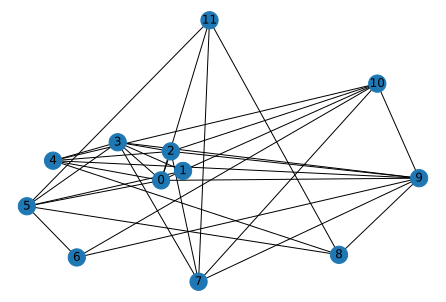

----------------------------------Comparision of Algorithms----------------------------------


,Vertex Covers,Length,Ratio wrt Brute Force
Algorithms,,,
Brute Force,"[2, 3, 4, 5, 9, 10, 11]",7,1.000000
G1 Algo,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",10,1.428571
G2 Algo,"[9, 0, 3, 2, 4, 5, 10, 7, 8]",9,1.285714
MM Algo,"[11, 7, 9, 3, 10, 6, 1, 5, 0, 2, 8, 4]",12,1.714286
RA Algo,"[0, 3, 1, 4, 2, 6, 5, 7, 9, 8]",10,1.376190
RLP,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",12,1.714286


In [ ]:
example_n = 12
example_p = 0.5
example_seed = 1203
example_directed = False
example_graph_object = nx.gnp_random_graph(example_n, example_p, example_seed, example_directed)
plot_graph(example_graph_object)
_ = compare(example_graph_object, RUNS_FOR_RA = 30, PRINT = True, lp = "none", COMPARE = "size")

## Weighted Vertex Cover

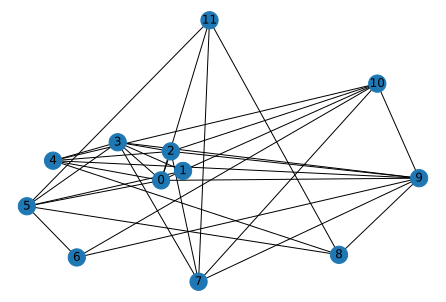

RLP Vertex Cover: [0, 2, 3, 5, 8, 9, 10, 11] Sum: 64
ILP Vertex Cover: [0, 2, 3, 5, 8, 9, 10, 11] Sum: 64
RA Vertex Cover: [2, 3, 4, 0, 1, 6, 5, 7, 9, 8] Sum: 117


In [ ]:
MIN_WEIGHT = 1
MAX_WEIGHT = 25
example_weights = [random.randint(MIN_WEIGHT,MAX_WEIGHT) for i in range(example_n)]
plot_graph(example_graph_object)
weighted_vertex_cover_rlp = rlp(example_graph_object,example_weights)
print("RLP Vertex Cover:",weighted_vertex_cover_rlp,"Sum:",sum([example_weights[x] for x in weighted_vertex_cover_rlp]))
weighted_vertex_cover_ilp = ilp(example_graph_object,example_weights)
print("ILP Vertex Cover:",weighted_vertex_cover_ilp,"Sum:",sum([example_weights[x] for x in weighted_vertex_cover_ilp]))
weighted_vertex_cover_ra = ra_algo(example_graph_object,example_weights,WEIGHTED = True)
print("RA Vertex Cover:",weighted_vertex_cover_ra,"Sum:",sum([example_weights[x] for x in weighted_vertex_cover_ra]))

## Multiple RA Algorithm

One Run of RA Algorithm: [2, 0, 1, 4, 5, 3, 6, 9, 7, 8] 

Standard Deviation: 0.5587684871413404
Average over 30 Runs: 9.566666666666666 



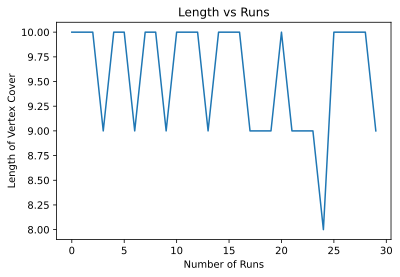

In [ ]:
print("One Run of RA Algorithm:",ra_algo(example_graph_object,[]),"\n")
_,_ = multiple_ra_algo(example_graph_object,[], RUNS = 30, PRINT = True)

## Hamming Distance

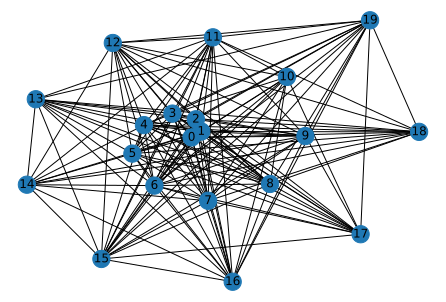

Comparision of Hamming Distances with Brute Force


,Min Hamming Dist
G1 Algo,2
G2 Algo,1
MM Algo,3
RA Algo,2
RLP Algo,3


In [ ]:
example_2_n = 20
example_2_p = 0.8
example_2_seed = 1203
example_2_directed = False
example_2_graph_object = nx.gnp_random_graph(example_2_n, example_2_p, example_2_seed, example_2_directed)
example_2_graph = nx.to_dict_of_lists(example_2_graph_object)
plot_graph(example_2_graph_object)
_ = compare_hamming_distances(example_2_graph_object, PRINT = True)

# Comparision of Algorithms

## Execution Time

**Implementation:**
- Since brute force increases highly exponentially, it compresses the other graphs.
- We have displayed 2 other graphs for execution time without brute force.


--------------------- Time taken vs N ---------------------


Average                      ... Standard Deviation                    
         N        g1        g2  ...                rlp       ilp     brute
0        5  0.000028  0.000034  ...           0.000062  0.000074  0.000002
1        6  0.000027  0.000032  ...           0.000054  0.000087  0.000001
2        7  0.000030  0.000036  ...           0.000063  0.000155  0.000003
3        8  0.000039  0.000045  ...           0.000065  0.000187  0.000006
4        9  0.000040  0.000045  ...           0.000058  0.000198  0.000011
5       10  0.000051  0.000057  ...           0.000067  0.000276  0.000027
6       11  0.000060  0.000066  ...           0.000074  0.000284  0.000056
7       12  0.000098  0.000083  ...           0.000078  0.000463  0.000119
8       13  0.000097  0.000091  ...           0.000137  0.000692  0.000264
9       14  0.000114  0.000167  ...           0.000153  0.000882  0.000621
10      15  0.000139  0.000102  ...           0.000130  0.001005  0.001151
11      16  0.000101  0.000080  ...           0.000154  0.000998  0.001708
12      17  0.000114  0.000087  ...           0.000142  0.000933  0.002325
13      18  0.000116  0.000092  ...           0.000171  0.001157  0.003827
14      19  0.000128  0.000102  ...           0.000155  0.001322  0.006915
15      20  0.000134  0.000107  ...           0.000188  0.001593  0.014222

[16 rows x 16 columns]


--------------------- Time taken vs P ---------------------


Average                      ... Standard Deviation                    
         P        g1        g2  ...                rlp       ilp     brute
0     0.05  0.000035  0.000034  ...           0.000063  0.000130  0.001083
1     0.10  0.000042  0.000037  ...           0.000037  0.000131  0.006238
2     0.15  0.000047  0.000040  ...           0.000057  0.000243  0.009365
3     0.20  0.000053  0.000046  ...           0.000115  0.000368  0.013572
4     0.25  0.000057  0.000047  ...           0.000108  0.000349  0.015132
5     0.30  0.000067  0.000054  ...           0.000126  0.000444  0.016646
6     0.35  0.000068  0.000058  ...           0.000154  0.000507  0.017357
7     0.40  0.000071  0.000062  ...           0.000136  0.000605  0.017718
8     0.45  0.000079  0.000070  ...           0.000148  0.000563  0.017956
9     0.50  0.000083  0.000075  ...           0.000130  0.000557  0.018029
10    0.55  0.000088  0.000081  ...           0.000117  0.000694  0.018110
11    0.60  0.000116  0.000082  ...           0.000141  0.000835  0.018045
12    0.65  0.000090  0.000085  ...           0.000147  0.000754  0.018126
13    0.70  0.000092  0.000086  ...           0.000157  0.000801  0.018148
14    0.75  0.000095  0.000119  ...           0.000181  0.000974  0.018072
15    0.80  0.000100  0.000123  ...           0.000271  0.001161  0.017996
16    0.85  0.000110  0.000131  ...           0.000242  0.001389  0.018015
17    0.90  0.000110  0.000103  ...           0.000244  0.001622  0.017816
18    0.95  0.000110  0.000103  ...           0.000209  0.001854  0.017716
19    1.00  0.000129  0.000097  ...           0.000245  0.002378  0.017539

[20 rows x 16 columns]

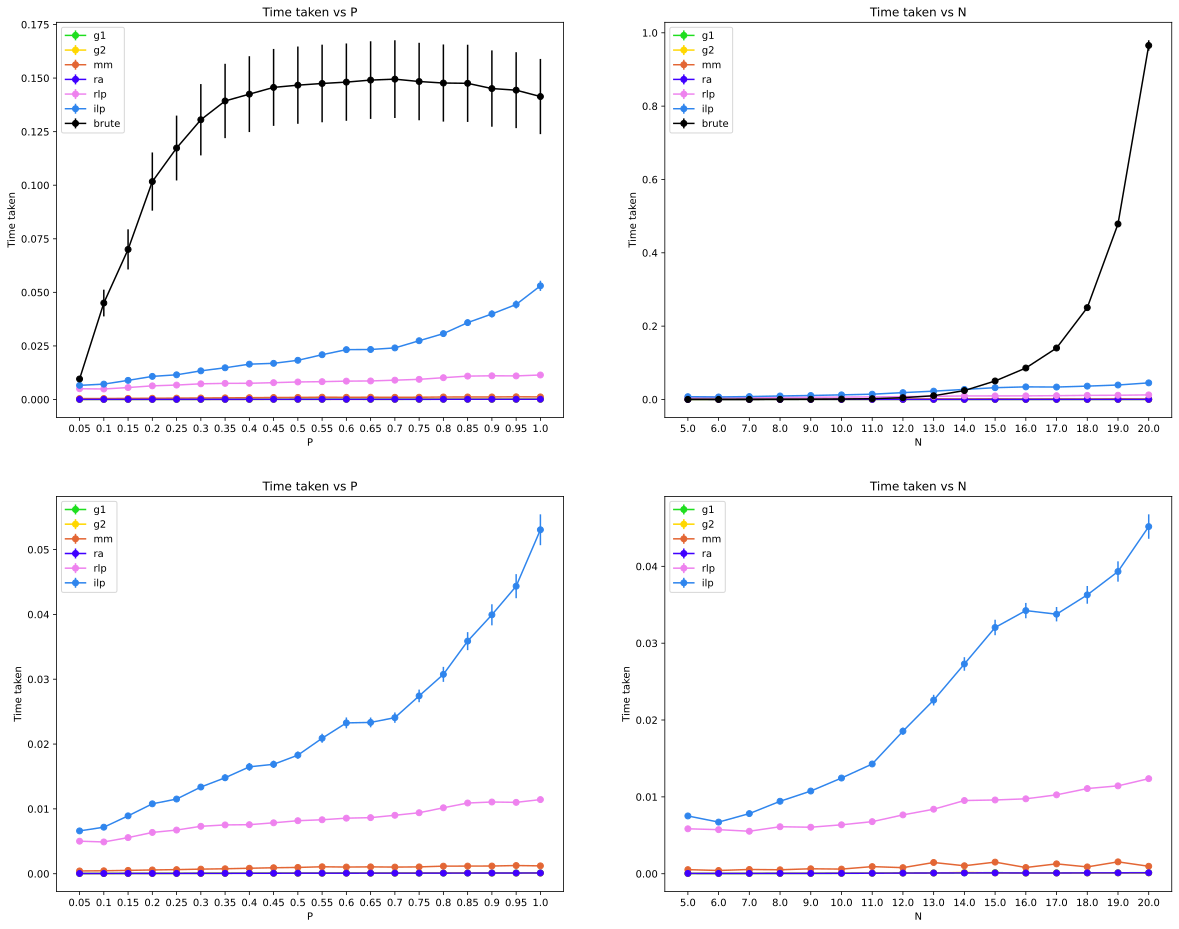

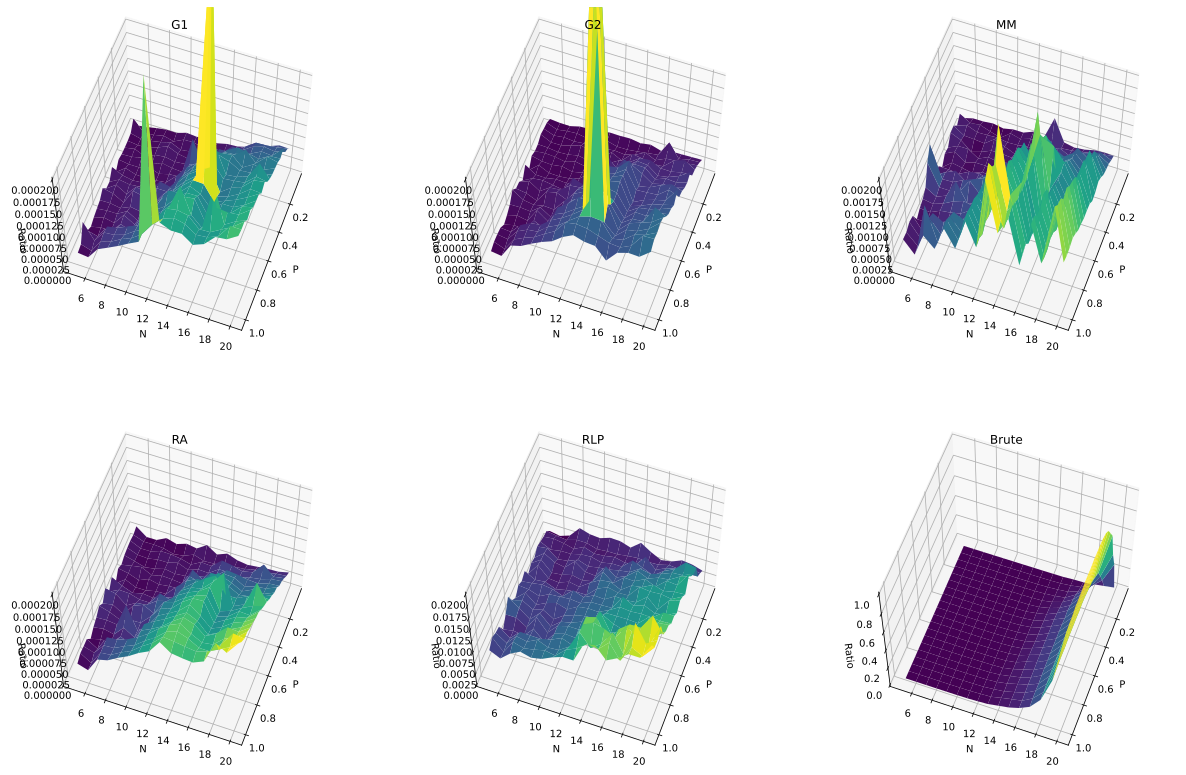

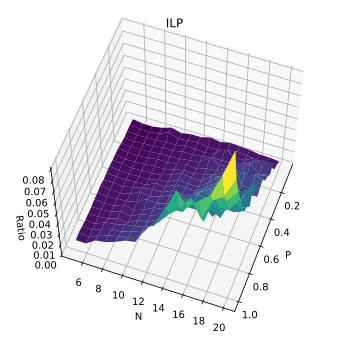

In [ ]:
compare_algos(5,20,0.05,1,0.05,lp = "none",COMPARE = "time")

**Findings:**

- As expected, execution time for the brute force and ILP algorithm increases exponentially with n.
- For small p, Brute Force performs faster, because for sparse graphs, early stopping occurs faster as all the edges are covered by a smaller sized subset of vertices.
- Execution time for ILP algorithm grows at a smaller rate wrt both n and p than Brute Force.
- For small n, Execution time for ILP is higher than brute force but is overtaken by brute force due to the difference in growth rate.
- Other algorithms are much more efficient.
- RLP increases faster than other approximation algorithms but is better than ILP and Brute Force.


## Performance Ratios

### Unweighted Vertex Cover


--------------------- Ratio of Vertex Covers vs N ---------------------


Average                      ... Standard Deviation                    
         N        g1        g2  ...                 mm        ra       rlp
0        5  1.272778  1.025833  ...           0.016599  0.004431  0.007638
1        6  1.270476  1.063333  ...           0.013414  0.004073  0.009099
2        7  1.232306  1.060167  ...           0.015590  0.003658  0.009019
3        8  1.272324  1.061917  ...           0.013152  0.003485  0.005889
4        9  1.272972  1.053762  ...           0.014846  0.003997  0.007541
5       10  1.285937  1.077256  ...           0.014205  0.004541  0.008954
6       11  1.261323  1.090101  ...           0.016257  0.004041  0.008757
7       12  1.307246  1.084998  ...           0.014457  0.004165  0.007081
8       13  1.264572  1.090167  ...           0.015376  0.004102  0.007421
9       14  1.263483  1.098407  ...           0.014509  0.004215  0.006772
10      15  1.262064  1.106927  ...           0.014882  0.004392  0.008337
11      16  1.220113  1.094513  ...           0.014228  0.003865  0.008485
12      17  1.244930  1.094311  ...           0.015160  0.004458  0.008036
13      18  1.245828  1.108225  ...           0.014564  0.004664  0.008159
14      19  1.230115  1.121381  ...           0.014684  0.004105  0.008593
15      20  1.197816  1.116079  ...           0.014101  0.004108  0.007464

[16 rows x 12 columns]


--------------------- Ratio of Vertex Covers vs P ---------------------


Average                      ... Standard Deviation                    
         P        g1        g2  ...                 mm        ra       rlp
0     0.05  1.262593  1.031458  ...           0.001095  0.005525  0.016409
1     0.10  1.383418  1.073700  ...           0.002138  0.003672  0.010746
2     0.15  1.376670  1.116627  ...           0.003988  0.004103  0.007226
3     0.20  1.371604  1.109157  ...           0.005595  0.004040  0.009618
4     0.25  1.389052  1.108044  ...           0.006868  0.002287  0.009968
5     0.30  1.356610  1.123883  ...           0.008981  0.001822  0.011265
6     0.35  1.353042  1.116337  ...           0.010943  0.002046  0.010723
7     0.40  1.335045  1.119985  ...           0.011064  0.002748  0.009592
8     0.45  1.328192  1.111324  ...           0.011093  0.002483  0.008375
9     0.50  1.285784  1.115986  ...           0.009631  0.001869  0.006708
10    0.55  1.274544  1.113186  ...           0.008856  0.002121  0.006506
11    0.60  1.248892  1.100751  ...           0.008734  0.001983  0.006227
12    0.65  1.237603  1.095494  ...           0.008397  0.002146  0.006227
13    0.70  1.217654  1.075555  ...           0.007632  0.002830  0.005740
14    0.75  1.187966  1.072222  ...           0.006894  0.002493  0.006967
15    0.80  1.177140  1.066255  ...           0.006289  0.002241  0.007273
16    0.85  1.142329  1.059138  ...           0.005049  0.001342  0.005716
17    0.90  1.121116  1.047660  ...           0.005314  0.001890  0.005875
18    0.95  1.081099  1.027458  ...           0.004332  0.000790  0.003998
19    1.00  1.000000  1.000000  ...           0.003751  0.000000  0.003454

[20 rows x 12 columns]

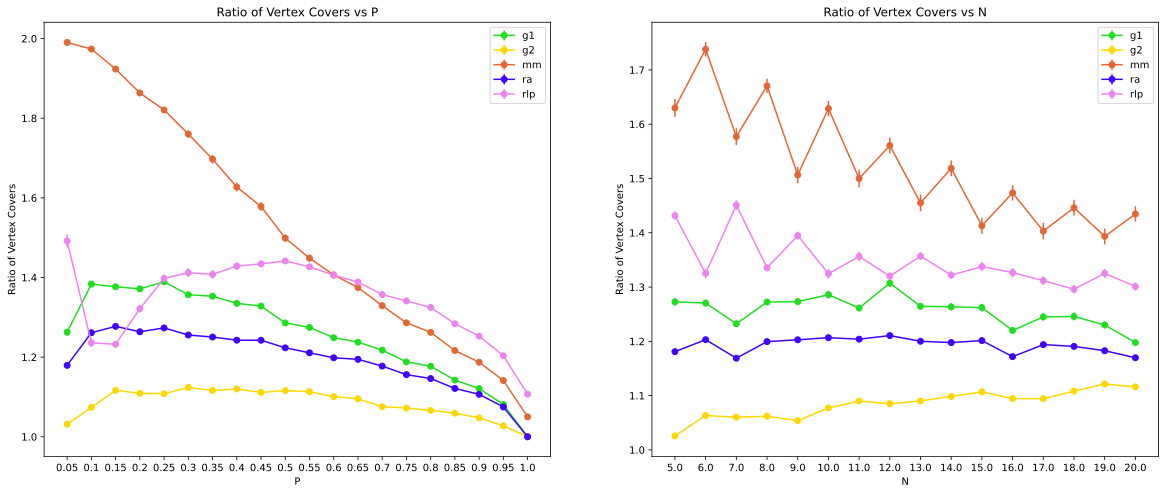

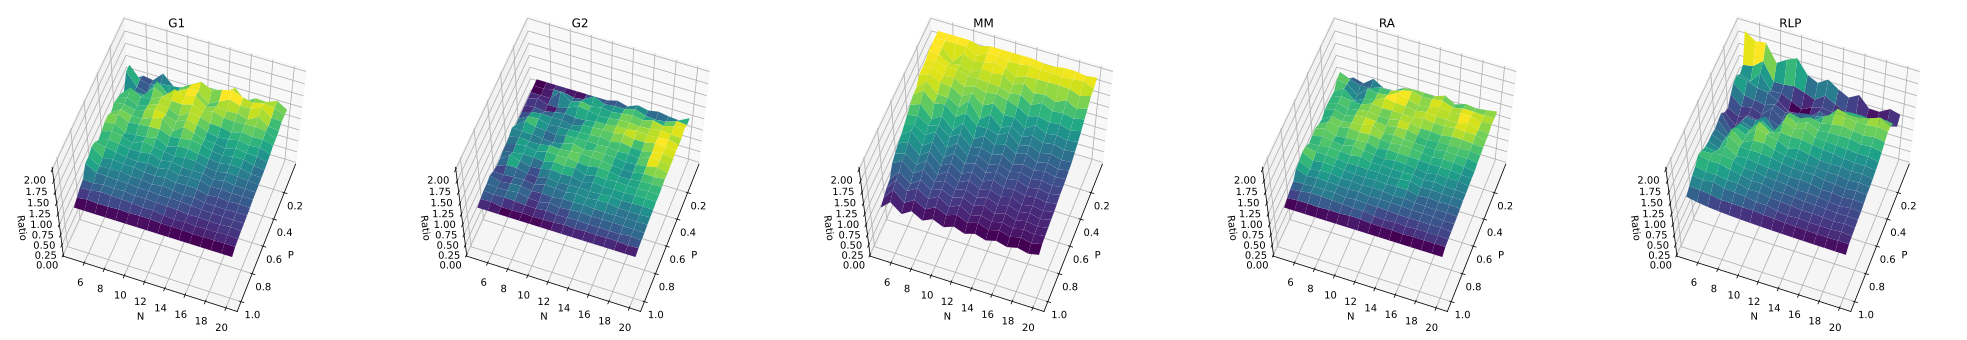

In [ ]:
compare_algos(5,20,0.05,1,0.05,lp = "ilp", COMPARE = "size")

**Findings:**
- Ratio for MM Algorithm is high at lower values of p, since the graph is sparse and most vertices belong to only 1 edge, hence MM picks two vertices, even though one is sufficient.
- MM Algorithm v/s n oscillates for odd and even number of vertices:
    - It spikes on even vertices as for odd vertices, we have a vertex which is never picked but for even vertices, all pairs are selected, hence for odd number of vertices, vertex cover is shorter.
    - This spiking behaviour decreases in amplitude as n increases, since the difference of including 1 vertex becomes negligible.
- G1, G2 and RA decrease slightly with an increase in p, as for denser graphs, there are more vertices with a higher degree, so we can cover multiple edges by including one vertex.
- For other algorithms, the ratio with n remains pretty much constant.
- G2 algorithm performs the best as it's ratio is closest to 1. This is because of sorted iteration on degree of vertices.
- RA algorithm lies between G1 and G2 algorithms even though it has a similar algorithmic structure since it incorporates a randomized approach which averages out the length.

### Weighted Vertex Cover


--------------------- Weighted Vertex Covers wrt ILP vs N ---------------------


Average                     Standard Deviation                    
         N   RLP/ILP    RA/ILP                  N   RLP/ILP    RA/ILP
0        5  1.216691  1.675343                  5  0.008078  0.014914
1        6  1.291084  1.582071                  6  0.010812  0.016472
2        7  1.351044  1.419335                  7  0.009995  0.008743
3        8  1.321096  1.439207                  8  0.010411  0.009479
4        9  1.357815  1.449036                  9  0.010715  0.009291
5       10  1.340945  1.398301                 10  0.009837  0.007663
6       11  1.353216  1.428339                 11  0.011414  0.012974
7       12  1.341093  1.374491                 12  0.010338  0.008116
8       13  1.375277  1.371095                 13  0.009543  0.008077
9       14  1.372662  1.359809                 14  0.009331  0.007227
10      15  1.366961  1.362405                 15  0.008992  0.008254
11      16  1.382799  1.327949                 16  0.009696  0.007365
12      17  1.377651  1.336122                 17  0.009119  0.008074
13      18  1.370300  1.327797                 18  0.010226  0.007577
14      19  1.362226  1.315922                 19  0.009085  0.007595
15      20  1.349754  1.297323                 20  0.010000  0.008437


--------------------- Weighted Vertex Covers wrt ILP vs P ---------------------


Average                     Standard Deviation                    
         P   RLP/ILP    RA/ILP                  P   RLP/ILP    RA/ILP
0     0.05  1.042717  1.699637               0.05  0.004800  0.015351
1     0.10  1.041068  1.641886               0.10  0.003228  0.008800
2     0.15  1.113337  1.603987               0.15  0.007499  0.012266
3     0.20  1.209976  1.660737               0.20  0.010810  0.017103
4     0.25  1.331220  1.500408               0.25  0.012601  0.006487
5     0.30  1.355280  1.516577               0.30  0.014774  0.009593
6     0.35  1.396870  1.489450               0.35  0.014455  0.009915
7     0.40  1.452593  1.467310               0.40  0.011214  0.010422
8     0.45  1.479018  1.464770               0.45  0.011895  0.012535
9     0.50  1.519331  1.382568               0.50  0.006695  0.005409
10    0.55  1.493003  1.361333               0.55  0.005658  0.004400
11    0.60  1.489747  1.365933               0.60  0.009151  0.009521
12    0.65  1.471901  1.337599               0.65  0.006158  0.006026
13    0.70  1.432035  1.296222               0.70  0.006192  0.006655
14    0.75  1.441762  1.271347               0.75  0.006589  0.004439
15    0.80  1.401629  1.282452               0.80  0.007234  0.006761
16    0.85  1.373179  1.233525               0.85  0.005828  0.004538
17    0.90  1.334844  1.223037               0.90  0.005387  0.004961
18    0.95  1.319616  1.180460               0.95  0.007261  0.002973
19    1.00  1.214141  1.101442               1.00  0.006600  0.003463

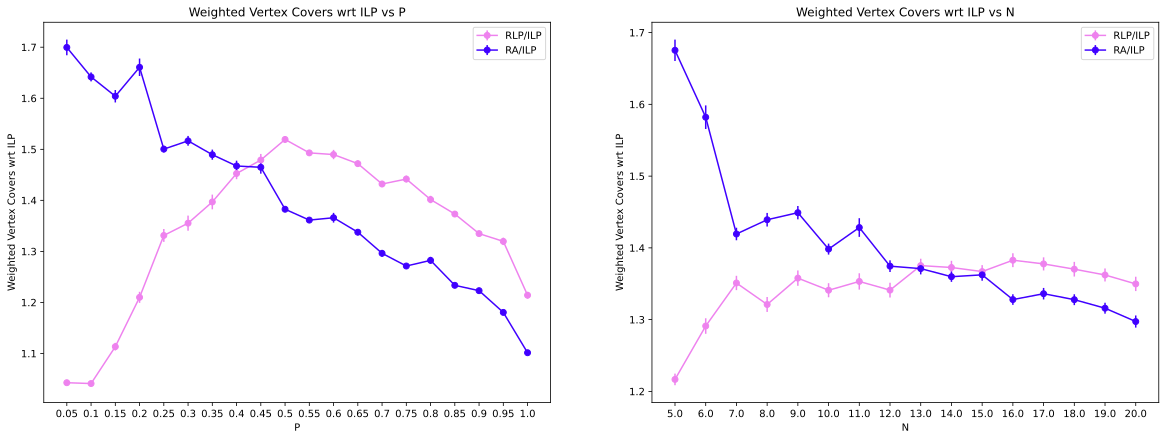

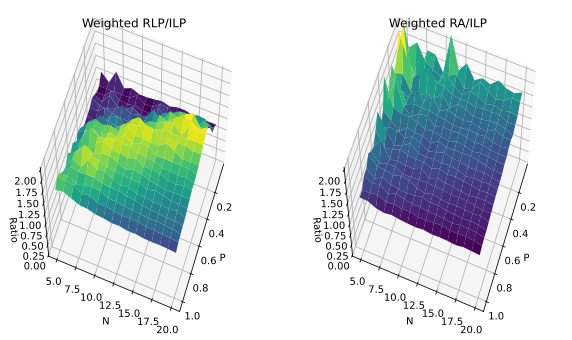

In [ ]:
compare_weighted(5,20,0.05,1,0.05,1,25)

**Findings:**
- RA decreases with increase in p, as for denser graphs, there are more vertices with a higher degree, so we can cover multiple edges by including one vertex.
- RA is high for lower values of n since picking a wrong vertex has a higher consequence, and since RA is randomized, there is always a probability that a wrong vertex will be picked in the beginning, making the ratio higher.
- For higher n, since there are more options available, this balances out.


## Hamming Distance


--------------------- Hamming Distance wrt Brute Force vs N ---------------------


Average                       ... Standard Deviation                              
         N     g1     g2     mm  ...                 g2        mm        ra       rlp
0        5  0.295  0.040  0.655  ...           0.004583  0.021993  0.008288  0.014096
1        6  0.260  0.110  1.365  ...           0.004975  0.022487  0.012774  0.029106
2        7  0.220  0.105  0.730  ...           0.004867  0.018378  0.012173  0.031459
3        8  0.200  0.130  1.540  ...           0.004213  0.022439  0.008958  0.028918
4        9  0.340  0.165  0.855  ...           0.007949  0.015849  0.012891  0.031602
5       10  0.340  0.225  1.685  ...           0.008496  0.020017  0.013989  0.035711
6       11  0.335  0.270  0.970  ...           0.009887  0.012659  0.012070  0.035794
7       12  0.485  0.430  1.815  ...           0.011948  0.014771  0.011099  0.033162
8       13  0.445  0.510  1.060  ...           0.013029  0.018262  0.011562  0.027077
9       14  0.420  0.620  1.860  ...           0.014457  0.011874  0.014195  0.029363
10      15  0.455  0.720  1.075  ...           0.016016  0.019992  0.015322  0.028305
11      16  0.440  0.715  1.080  ...           0.016376  0.009695  0.012639  0.010062
12      17  0.515  0.805  1.055  ...           0.018471  0.021993  0.018593  0.028810
13      18  0.575  0.960  1.990  ...           0.028213  0.016726  0.018926  0.027318
14      19  0.420  0.995  1.095  ...           0.024823  0.025665  0.027716  0.022151
15      20  0.370  1.140  1.955  ...           0.024413  0.019331  0.031420  0.021512

[16 rows x 12 columns]


--------------------- Hamming Distance wrt Brute Force vs P ---------------------


Average                             ... Standard Deviation                              
         P       g1       g2       mm  ...                 g2        mm        ra       rlp
0     0.05  0.43750  0.22500  1.60625  ...           0.014741  0.057089  0.035416  0.021392
1     0.10  0.38125  0.38125  1.37500  ...           0.026166  0.031367  0.044077  0.013298
2     0.15  0.30625  0.64375  1.21250  ...           0.041924  0.022521  0.045762  0.016897
3     0.20  0.17500  0.71250  1.21250  ...           0.040797  0.022194  0.025911  0.023385
4     0.25  0.15000  0.73750  1.28125  ...           0.039644  0.024329  0.034508  0.030619
5     0.30  0.12500  0.73125  1.32500  ...           0.035474  0.026099  0.025046  0.036475
6     0.35  0.13125  0.66875  1.35000  ...           0.037155  0.027333  0.021927  0.040195
7     0.40  0.14375  0.63125  1.38125  ...           0.029041  0.028403  0.016810  0.040018
8     0.45  0.22500  0.70000  1.38750  ...           0.030298  0.028885  0.016308  0.036374
9     0.50  0.28750  0.63750  1.41250  ...           0.021295  0.029554  0.009496  0.031790
10    0.55  0.38750  0.58125  1.41875  ...           0.020755  0.029992  0.013838  0.026837
11    0.60  0.46875  0.52500  1.41250  ...           0.019949  0.029800  0.012885  0.024395
12    0.65  0.53125  0.50000  1.43750  ...           0.020010  0.031005  0.013298  0.020989
13    0.70  0.61250  0.44375  1.41250  ...           0.020843  0.032915  0.011049  0.020696
14    0.75  0.66875  0.44375  1.37500  ...           0.018876  0.037467  0.014358  0.022844
15    0.80  0.71250  0.42500  1.37500  ...           0.017747  0.037467  0.015224  0.021732
16    0.85  0.66875  0.36875  1.25000  ...           0.018318  0.036644  0.020637  0.024705
17    0.90  0.65625  0.31250  1.18750  ...           0.017098  0.039644  0.023372  0.028970
18    0.95  0.57500  0.25625  1.06875  ...           0.015304  0.041500  0.025457  0.029458
19    1.00  0.00000  0.00000  0.50000  ...           0.000000  0.031250  0.000000  0.000000

[20 rows x 12 columns]

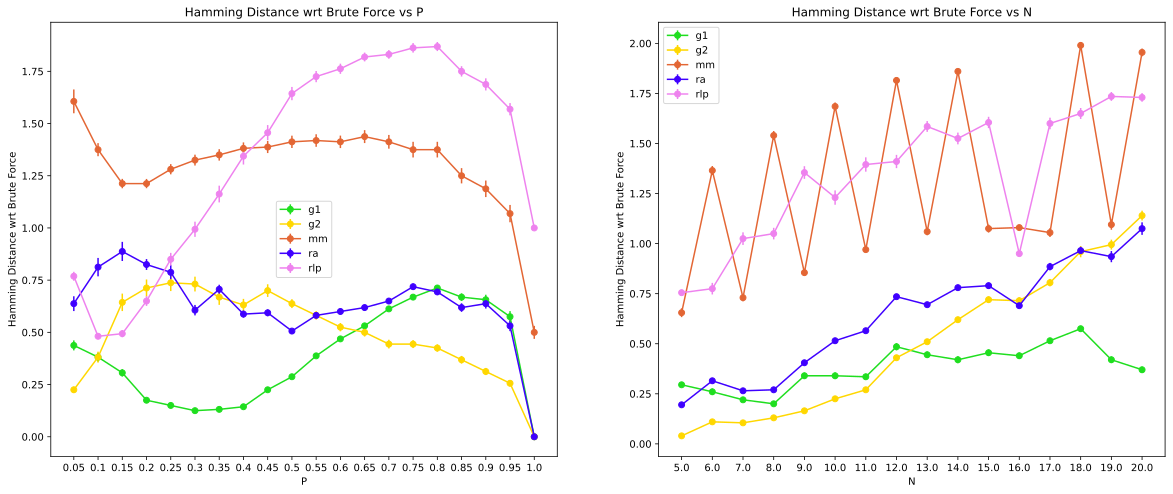

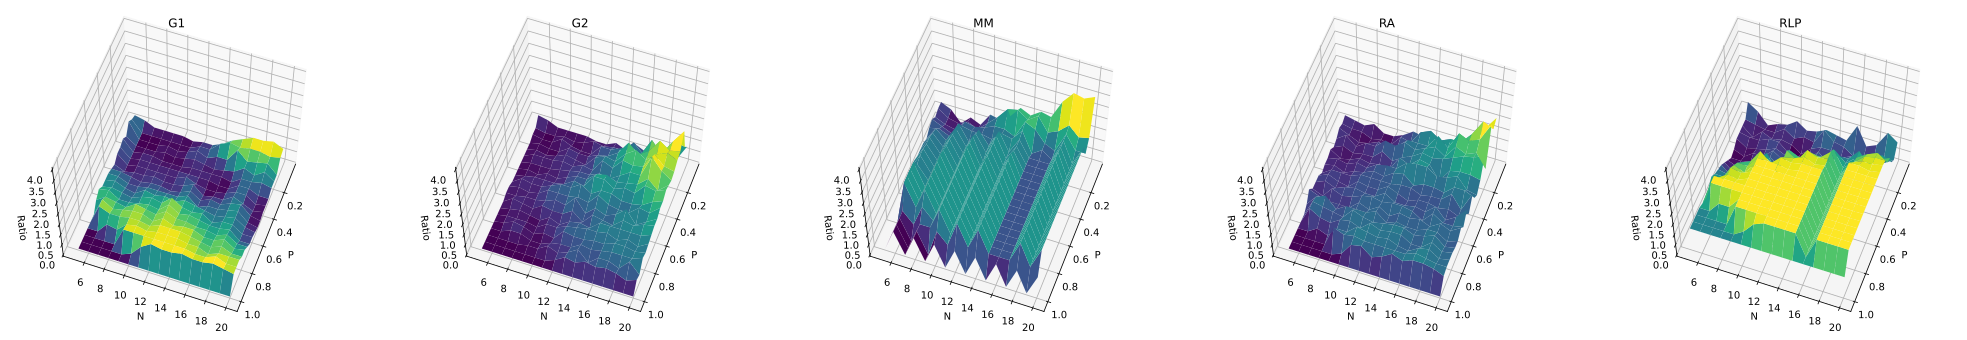

In [ ]:
compare_algos(5,20,0.05,1,0.05,COMPARE = "hamming")

**Findings:**
- MM Algorithm v/s n oscillates for odd and even number of vertices - it spikes on even vertices as for odd vertices, we have a vertex which is never picked but for even vertices, all pairs are selected, hence for odd number of vertices, vertex cover is shorter.
- Other algorithms increase with an increase in n, as expected.
- Hamming distance for MM Algorithm is high at lower values of p, since the graph is sparse and most vertices belong to only 1 edge, hence MM picks two vertices, even though one is sufficient. 
- At lower and higher values of p, hamming distances of other algorithms are less, since the ratios of 1s and 0s in the characteristic vector (of the vertex cover) is very skewed, so the XOR of these vectors cannot be that high.